In [382]:
from lib.functions0 import *
from lib.utility import *
import numpy as np
from scipy.linalg import expm
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
from qiskit.ignis.mitigation.measurement import  complete_meas_cal
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
#%load_ext autoreload
#%autoreload 2
import warnings
warnings.filterwarnings('ignore')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')

backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ibmqfactory.load_account:WARNING:2022-04-09 16:29:40,172: Credentials are already in use. The existing account in the session will be replaced.


In [383]:
import qiskit
qiskit.utils.mitigation.fitters.__file__

'C:\\Users\\asus\\AppData\\Roaming\\Python\\Python38\\site-packages\\qiskit\\utils\\mitigation\\fitters.py'

In [384]:
n_steps=100
time=np.pi/3
#initial_state={"110": 1}
shots = 32000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
H = np.array([[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

Had3=np.kron(H, np.kron(H,H))

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)
#Matrix(Had3)

Matrix([
[-0.5 - 0.866*I,                    0,                    0,                  0,                  0,                    0,                    0,              0],
[             0,       0.25 - 0.433*I,   0.00453 - 0.0079*I,                  0,   -0.755 - 0.425*I,                    0,                    0,              0],
[             0, -0.00454 + 0.00781*I,       -0.5 - 0.866*I,                  0, 0.00453 - 0.0079*I,                    0,                    0,              0],
[             0,                    0,                    0,     0.25 - 0.433*I,                  0, -0.00454 + 0.00781*I,     -0.745 - 0.441*I,              0],
[             0,     -0.745 - 0.441*I, -0.00454 + 0.00781*I,                  0,     0.25 - 0.433*I,                    0,                    0,              0],
[             0,                    0,                    0, 0.00453 - 0.0079*I,                  0,       -0.5 - 0.866*I, -0.00454 + 0.00781*I,              0],
[             0,   

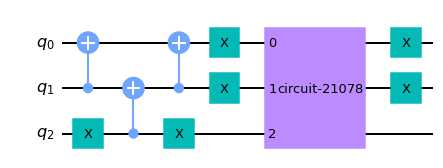

In [385]:
qr=QuantumRegister(3, name="q")
B_qc=QuantumCircuit(qr, name="B")
B_qc.x(qr[2])
B_qc.cx(qr[1],qr[0])
B_qc.cx(qr[2],qr[1])
B_qc.cx(qr[1],qr[0])
B_qc.x([qr[0],qr[1],qr[2]])
B_qc.append(Toffoli_gate,[qr[0],qr[1],qr[2]])
B_qc.x([qr[0],qr[1]])

B_qc.draw(output="mpl")

In [386]:
B=matrix_from_circuit(B_qc)
B

Matrix([
[  0,   0,   0,   0, 1.0,   0,   0,   0],
[  0,   0, 1.0,   0,   0,   0,   0,   0],
[  0, 1.0,   0,   0,   0,   0,   0,   0],
[1.0,   0,   0,   0,   0,   0,   0,   0],
[  0,   0,   0, 1.0,   0,   0,   0,   0],
[  0,   0,   0,   0,   0, 1.0,   0,   0],
[  0,   0,   0,   0,   0,   0, 1.0,   0],
[  0,   0,   0,   0,   0,   0,   0, 1.0]])

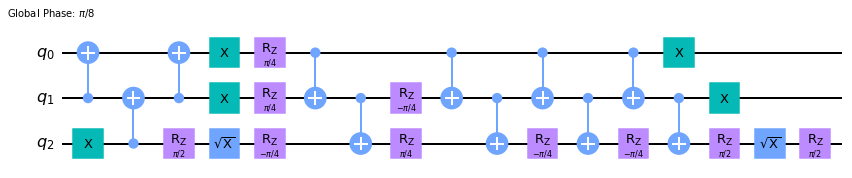

In [387]:
transpile(B_qc, basis_gates=["cx", "x", "rz", "sx"]).draw(output="mpl")

In [388]:
#for _ in range(n_steps): # here is computed the evolution operator numerically, with n_steps trotter steps.
#
#    numeric_evolution_matrix=(numeric_evolution_matrix*trotter_step_matrix_(2*time/n_steps)).evalf(precision)


M_N = B*trotterized*B.H
M_N = Matrix([M_N[0:4],M_N[8:12],M_N[16:20],M_N[24:28]])
M_N.evalf(5)

Matrix([
[    0.24994 - 0.43297*I, -0.0045427 + 0.0078115*I,      -0.7454 - 0.44087*I,                0],
[0.0045267 - 0.0078972*I,     -0.49998 - 0.86594*I, -0.0045427 + 0.0078115*I,                0],
[   -0.75447 - 0.42516*I,  0.0045267 - 0.0078972*I,      0.24994 - 0.43297*I,                0],
[                      0,                        0,                        0, -0.5 - 0.86602*I]])

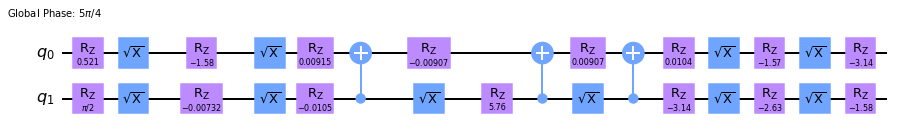

In [389]:
qc=QuantumCircuit(2, name="$M^N$")
qc.unitary(M_N,[0,1])    
M_N_qc=transpile(qc,basis_gates=['cx','x','sx','rz']) 

M_N_qc.draw(output="mpl")

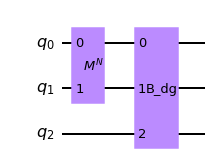

In [390]:
initial_state="000"

qr_U = QuantumRegister(3, name="q")
qc_U = QuantumCircuit(qr_U, name="evo")

### preparing the initial state

l=0
for k in [2,1,0]:
    if initial_state[l]=='1':
        qc_U.x(qr_U[k])
    l+=1

### appending the evolution

qc_U.append(M_N_qc,[qr_U[0],qr_U[1]])
qc_U.append(B_qc.inverse(),[qr_U[0],qr_U[1],qr_U[2]])

qc_U.draw(output="mpl")

In [391]:
U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

Matrix([
[      1.64733e-5 - 9.7432e-6*I,          1.022e-7 + 1.729e-7*I,        1.6577e-5 - 9.5707e-6*I, -0.5000000011 - 0.8660254027*I,                              0,                              0,                              0,                              0],
[-0.7544691345 - 0.4251588751*I,   0.004510263 - 0.0078875014*I,  0.2499422949 - 0.4329694559*I,        1.6577e-5 - 9.5707e-6*I,                              0,                              0,                              0,                              0],
[ 0.0045101626 - 0.0078876741*I, -0.4999840448 - 0.8659396308*I, -0.0045593697 + 0.0078208688*I,          -9.82e-8 - 1.743e-7*I,                              0,                              0,                              0,                              0],
[                             0,                              0,                              0,                              0,  0.2499422916 - 0.4329694557*I, -0.0045592696 + 0.0078210434*I, -0.7453995018 - 0.440867

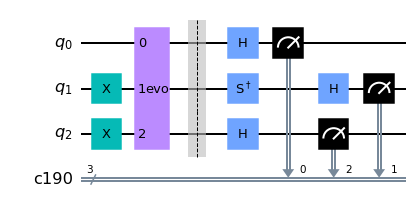

In [392]:
qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

In [393]:
qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

In [394]:
cal_circ[0].draw()

░ ┌─┐      
q17146_0: ─░─┤M├──────
           ░ └╥┘┌─┐   
q17146_1: ─░──╫─┤M├───
           ░  ║ └╥┘┌─┐
q17146_2: ─░──╫──╫─┤M├
           ░  ║  ║ └╥┘
  c191: 3/════╩══╩══╩═
              0  1  2

In [395]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [396]:
calib_circuits_identity = []
calib_circuits_itself = []

for i in state_labels:

    cr_cal_itself = ClassicalRegister(3)
    qr_cal_itself = QuantumRegister(3)
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.x(qr_cal_id)
    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_itself.x(qr_cal_itself[k])
        else:
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_itself.append(qc_U, qr_cal_itself)
    
    qc_cal_id.measure(qr_cal_id, cr_cal_id)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_identity.append(qc_cal_id)
    calib_circuits_itself.append(qc_cal_itself)

In [397]:
calib_circuits_identity[1].draw()

┌───┐┌──────┐     ┌─┐      
q17150_0: ┤ X ├┤0     ├─────┤M├──────
          ├───┤│      │┌───┐└╥┘┌─┐   
q17150_1: ┤ X ├┤1 evo ├┤ X ├─╫─┤M├───
          ├───┤│      │├───┤ ║ └╥┘┌─┐
q17150_2: ┤ X ├┤2     ├┤ X ├─╫──╫─┤M├
          └───┘└──────┘└───┘ ║  ║ └╥┘
  c195: 3/═══════════════════╩══╩══╩═
                             0  1  2

In [398]:
calib_circuits_itself[1].draw()

┌───┐┌──────┐┌─┐      
q17149_0: ┤ X ├┤0     ├┤M├──────
          └───┘│      │└╥┘┌─┐   
q17149_1: ─────┤1 evo ├─╫─┤M├───
               │      │ ║ └╥┘┌─┐
q17149_2: ─────┤2     ├─╫──╫─┤M├
               └──────┘ ║  ║ └╥┘
  c194: 3/══════════════╩══╩══╩═
                        0  1  2

In [399]:
job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])

In [400]:
meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

In [401]:
Matrix(meas_fitter_qiskit.cal_matrix)

Matrix([
[     0.941,  0.0506875,     0.0315,      0.002,   0.030125, 0.00171875, 0.00115625,    6.25e-5],
[ 0.0185625,  0.9091875,  0.0006875,  0.0320625,  0.0006875, 0.03209375,          0, 0.00109375],
[0.01046875,   0.000625, 0.91990625, 0.05071875, 0.00040625,          0,  0.0303125,    0.00175],
[0.00021875, 0.01021875, 0.01846875, 0.88678125,          0,  0.0003125, 0.00071875,   0.027625],
[0.02903125,     0.0015,    0.00125,    6.25e-5,    0.93875, 0.04815625, 0.03228125, 0.00140625],
[0.00040625,  0.0275625,          0, 0.00096875,  0.0191875, 0.90665625, 0.00071875, 0.03121875],
[ 0.0003125,          0,   0.027625,    0.00175, 0.01059375,  0.0005625,  0.9163125, 0.04759375],
[         0, 0.00021875,  0.0005625, 0.02565625,    0.00025,     0.0105,     0.0185,    0.88925]])

In [402]:
Matrix(meas_fitter_our_identity.cal_matrix)

Matrix([
[  0.888375, 0.06090625, 0.04621875,      0.009, 0.03540625, 0.00334375,     0.0025,   0.009875],
[0.03253125, 0.86059375,      0.007, 0.04496875,   0.002125, 0.03746875, 0.01059375, 0.00203125],
[0.02546875,    0.00725, 0.87034375, 0.05934375, 0.00184375,   0.009875,  0.0358125,  0.0031875],
[   0.00625, 0.02434375, 0.03221875,     0.8415, 0.00884375,    0.00125,  0.0018125,   0.033375],
[0.03309375,    0.00325, 0.00215625, 0.01009375, 0.88840625, 0.06384375, 0.04621875, 0.00990625],
[ 0.0024375,  0.0326875, 0.00809375, 0.00190625, 0.03271875,   0.853125, 0.00846875,  0.0436875],
[  0.001375,  0.0096875,  0.0318125, 0.00265625, 0.02409375,      0.007,  0.8630625,  0.0611875],
[0.01046875, 0.00128125, 0.00215625, 0.03053125,  0.0065625, 0.02409375, 0.03153125,    0.83675]])

In [403]:
U_tilde_identity=meas_fitter_our_identity.cal_matrix
U_tilde_itself=meas_fitter_our_itself.cal_matrix
U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

In [404]:
def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A

In [405]:
qr_basi = QuantumRegister(3)
qc_basi = QuantumCircuit(qr_basi)

qcs_basis = state_tomography_circuits(qc_basi, qr_basi)

qcs_basis[0].remove_final_measurements()

qcs_basis[16].draw()

░ ┌─────┐ ┌───┐      ┌─┐   
q18450_0: ─░─┤ Sdg ├─┤ H ├──────┤M├───
           ░ └─┬─┬─┘ └───┘      └╥┘   
q18450_1: ─░───┤M├───────────────╫────
           ░   └╥┘  ┌─────┐┌───┐ ║ ┌─┐
q18450_2: ─░────╫───┤ Sdg ├┤ H ├─╫─┤M├
           ░    ║   └─────┘└───┘ ║ └╥┘
  c208: 3/══════╩════════════════╩══╩═
                1                0  2

In [406]:
meas_fitter_qiskit.cal_matrix

array([[9.4100000e-01, 5.0687500e-02, 3.1500000e-02, 2.0000000e-03,
        3.0125000e-02, 1.7187500e-03, 1.1562500e-03, 6.2500000e-05],
       [1.8562500e-02, 9.0918750e-01, 6.8750000e-04, 3.2062500e-02,
        6.8750000e-04, 3.2093750e-02, 0.0000000e+00, 1.0937500e-03],
       [1.0468750e-02, 6.2500000e-04, 9.1990625e-01, 5.0718750e-02,
        4.0625000e-04, 0.0000000e+00, 3.0312500e-02, 1.7500000e-03],
       [2.1875000e-04, 1.0218750e-02, 1.8468750e-02, 8.8678125e-01,
        0.0000000e+00, 3.1250000e-04, 7.1875000e-04, 2.7625000e-02],
       [2.9031250e-02, 1.5000000e-03, 1.2500000e-03, 6.2500000e-05,
        9.3875000e-01, 4.8156250e-02, 3.2281250e-02, 1.4062500e-03],
       [4.0625000e-04, 2.7562500e-02, 0.0000000e+00, 9.6875000e-04,
        1.9187500e-02, 9.0665625e-01, 7.1875000e-04, 3.1218750e-02],
       [3.1250000e-04, 0.0000000e+00, 2.7625000e-02, 1.7500000e-03,
        1.0593750e-02, 5.6250000e-04, 9.1631250e-01, 4.7593750e-02],
       [0.0000000e+00, 2.1875000e-04, 5.6

In [407]:
C_matrices_itself = []
C_matrices_identity = []

C_itself = np.matmul(U_tilde_itself, np.linalg.inv(U_ideal))
C_identity = U_tilde_identity

for base in qcs_basis:
    
    base.remove_final_measurements()

    base_matrix = np.matrix(matrix_from_cirquit(base, type="numpy"))
    base_matrix_H = base_matrix.getH()

    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), U_tilde_itself, np.linalg.inv(U_ideal),  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
    C_aus_identity = np.matmul(base_matrix, np.matmul(C_identity, base_matrix_H))

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))

In [408]:
from copy import deepcopy

meas_fitters_identity = []
meas_fitters_itself = []

for C_new in C_matrices_identity:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_identity)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_identity.append(meas_fitter_our_aus)

for C_new in C_matrices_itself:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_itself)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_itself.append(meas_fitter_our_aus)

In [409]:
target_state = (One^One^Zero).to_matrix()
#target_state = (Zero^One^One).to_matrix()


fids=np.zeros(4)

raw_res=deepcopy(job_tomo.result())
qiskit_res=deepcopy(raw_res)
identity_res=deepcopy(raw_res)
itself_res=deepcopy(raw_res)

In [410]:
raw_res.get_counts(-1)

{'101': 544,
 '011': 19994,
 '111': 1145,
 '100': 562,
 '010': 1420,
 '110': 7074,
 '001': 1064,
 '000': 197}

In [411]:
for i in range(27):

    old_counts=raw_res.get_counts(i)
    new_counts_qiskit = meas_fitter_qiskit.filter.apply(old_counts, method="least_squares")
    qiskit_res.results[i].data.counts = new_counts_qiskit

    new_counts_id = meas_fitters_identity[i].filter.apply(old_counts, method="least_squares")
    identity_res.results[i].data.counts = new_counts_id

    new_counts_it = meas_fitters_itself[i].filter.apply(old_counts, method="least_squares")
    itself_res.results[i].data.counts = new_counts_it

In [412]:
itself_res.get_counts(-1)

{'000': 32000.0}

In [413]:
It_comp=occurrences_to_vector(itself_res.get_counts(-1))/(shots)
It_H=np.dot(Had3,It_comp)
Matrix(It_H)

Matrix([
[0.353553390593274],
[0.353553390593274],
[0.353553390593274],
[0.353553390593274],
[0.353553390593274],
[0.353553390593274],
[0.353553390593274],
[0.353553390593274]])

In [414]:
itself_res.get_counts(0)

{'111': 32000.0}

In [415]:
identity_res.get_counts(-1)

{'000': 5.78598877542285e-09,
 '001': 1.2575419323893588e-08,
 '010': 3.7851656153998905e-08,
 '011': 23580.23765051628,
 '100': 7.928278037087977e-09,
 '101': 361.37887418200364,
 '110': 7975.044178225243,
 '111': 83.33929701233265}

In [416]:
fids[0] = fidelity_count(raw_res, qcs_tomo, target_state)
fids[1] = fidelity_count(qiskit_res, qcs_tomo, target_state)
fids[2] = fidelity_count(identity_res, qcs_tomo, target_state)
fids[3] = fidelity_count(itself_res, qcs_tomo, target_state)

fids

array([0.22139242, 0.23945562, 0.24005156, 0.07178469])